In [1]:
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

In [2]:
fname = "2020_11_12.hdf"
dset_name = "1605227438 find R0 F1"

dset_names = [dset_name]
devices = ('Laser Lock', 'Wavelength', 'ZaberTMM')

In [3]:
pmt_channel = 1
shutter_channel = 2

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [4]:
attr_name = 'Laser Lock SetLockPointSeed2'
scan_data = {}
for idx in range(1,len(pxie)+1):
    attr = pxie_attrs[idx][attr_name]
    scan_data[attr] = {'open': [], 'closed': []}

In [5]:
for idx in range(1,len(pxie)+1):
    freq = float(pxie_attrs[idx][attr_name])
    
    traces = pxie[idx].copy()
    pmt = -traces[:,pmt_channel].astype(float)
    pmt -= np.mean(pmt[150:250])
    shutter_state = traces[:,shutter_channel].mean() > 2e4
    if shutter_state:
        scan_data[freq]['open'].append(pmt)
    else:
        scan_data[freq]['closed'].append(pmt)

In [7]:
freq_ratio = {}
for freq, traces in scan_data.items():
    io = np.trapz(np.mean(traces['open'], axis = 0)[200:])
    ic = np.trapz(np.mean(traces['closed'], axis = 0)[200:])
    freq_ratio[freq] = io/ic

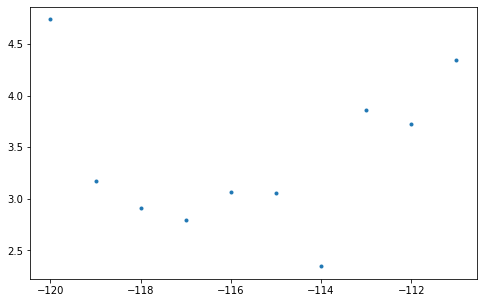

In [8]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(freq_ratio.keys(), freq_ratio.values(), '.')

In [9]:
from astropy import constants
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from astropy.modeling import functional_models

In [10]:
def lorentzian(x, μ, fwhm):
    y = (x-μ)/(fwhm/2)
    return 1/(1+y**2)

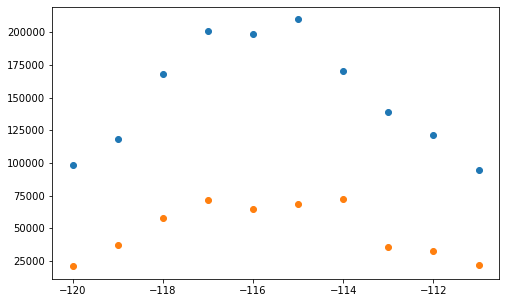

In [15]:
f,do, dc = [],[],[]
fig, ax = plt.subplots(figsize = (8,5))
for freq, traces in scan_data.items():
    io = np.trapz(np.mean(traces['open'], axis = 0)[200:])
    ic = np.trapz(np.mean(traces['closed'], axis = 0)[200:])
    ax.plot(freq, io, '.', ms = 12, color = 'C0')
    ax.plot(freq, ic, '.', ms = 12, color = 'C1')
    f.append(freq)
    do.append(io)
    dc.append(ic)
f = np.array(f)
do = np.array(do)
dc = np.array(dc)

-115.76


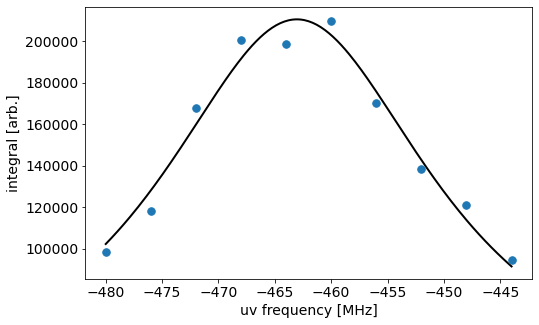

In [17]:
d = do.copy()
_f = np.linspace(f.min(), f.max(), 201)

fit_fun = lambda x,a,μ,fwhm,c: a*lorentzian(x,μ,fwhm)+c

popt, pcov = curve_fit(fit_fun, f*4, d, p0 = [25000,-116*4, 14, 30e3])

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_f*4, fit_fun(_f*4, *popt), 'k', lw = 2)
ax.plot(f*4, d, '.', color = 'C0', ms = 15)

ax.set_xlabel('uv frequency [MHz]')
ax.set_ylabel('integral [arb.]')

set_fontsize(ax, 14)

print(f'{popt[1]/4:.2f}')

-115.73


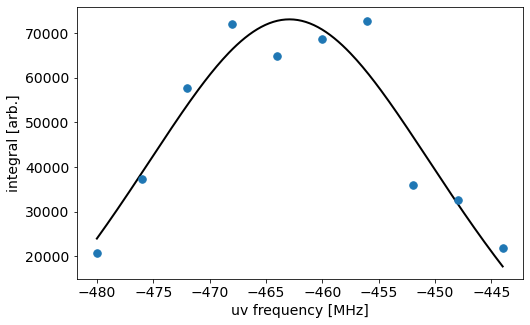

In [18]:
d = dc.copy()
_f = np.linspace(f.min(), f.max(), 201)

fit_fun = lambda x,a,μ,fwhm,c: a*lorentzian(x,μ,fwhm)+c

popt, pcov = curve_fit(fit_fun, f*4, d, p0 = [25000,-116*4, 14, 30e3])

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_f*4, fit_fun(_f*4, *popt), 'k', lw = 2)
ax.plot(f*4, d, '.', color = 'C0', ms = 15)

ax.set_xlabel('uv frequency [MHz]')
ax.set_ylabel('integral [arb.]')

set_fontsize(ax, 14)

print(f'{popt[1]/4:.2f}')